In [1]:
import pandas as pd
import numpy as np
import tables
import seaborn as sns
import xgboost as xgb

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

import imblearn.over_sampling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

from collections import OrderedDict

In [2]:
merged_song_data_clean = pd.read_csv('merged_song_data_clean.csv')

In [3]:
X_data = merged_song_data_clean.loc[:,['artist_name', 'title', 'artist_familiarity', 'artist_hotttnesss', 'duration',\
                                       'end_of_fade_in', 'key', 'loudness', 'mode', 'start_of_fade_out', 'tempo',\
                                       'time_signature', 'year']]
y_data = merged_song_data_clean['isin_hot100']

(array([1782.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          27.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

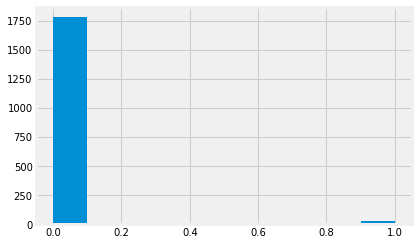

In [4]:
plt.hist(y_data)

In [5]:
y_data.value_counts()

0    1782
1      27
Name: isin_hot100, dtype: int64

In [6]:
X, x_test, y, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=42)

In [7]:
selection1 = ['artist_hotttnesss']

In [8]:
selection2 = ['artist_familiarity', 'artist_hotttnesss', 'duration', 'key', 'loudness', 'mode', 'tempo', 'time_signature', 'year']

(array([538.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   5.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

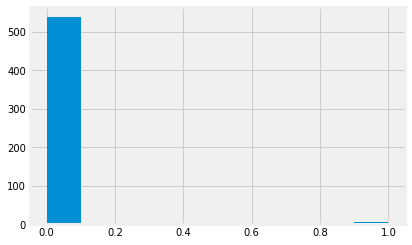

In [9]:
plt.hist(y_test)

In [10]:
y.value_counts()

0    1244
1      22
Name: isin_hot100, dtype: int64

## Baseline ##

In [11]:
lr = LogisticRegression() 
lr.fit(X.loc[:,selection1], y)
y_pred = lr.predict(x_test.loc[:,selection1])

print('Logistic Regression on 1 Feature; Test F1: %.3f, Test AUC: %.3f, RMSE: %.3f' % \
      (f1_score(y_pred, y_test), roc_auc_score(y_test, lr.predict_proba(x_test.loc[:,selection1])[:,1]), np.sqrt(np.sum((y_pred - y_test)**2)/len(y_test))))

Logistic Regression on 1 Feature; Test F1: 0.000, Test AUC: 0.570, RMSE: 0.096


/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


In [12]:
smote = imblearn.over_sampling.SMOTE(ratio=.4, random_state = 42) 
    
X_tr_smote, y_tr_smote = smote.fit_sample(X.loc[:,selection1], y)

lr_smote = LogisticRegression() 
lr_smote.fit(X_tr_smote, y_tr_smote)
y_pred = lr_smote.predict(x_test.loc[:,selection1])

print('Logistic Regression on SMOTE Train Data, ratio 0.4; Test F1: %.3f, Test AUC: %.3f, Test RMSE: %.3f' % \
      (f1_score(lr_smote.predict(x_test.loc[:,selection1]), y_test), roc_auc_score(y_test, lr_smote.predict_proba(x_test.loc[:,selection1])[:,1]), np.sqrt(np.sum((y_pred - y_test)**2)/len(y_test))))

Logistic Regression on SMOTE Train Data, ratio 0.4; Test F1: 0.000, Test AUC: 0.570, Test RMSE: 0.215


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


## Multiple Linear Regression ##

In [13]:
std = StandardScaler()
x_train_cat = pd.get_dummies(X.loc[:,selection2], columns=['key', 'time_signature'])
x_test_cat = pd.get_dummies(x_test.loc[:,selection2], columns=['key', 'time_signature'])
x_train_scaled = std.fit_transform(x_train_cat)
x_test_scaled = std.fit_transform(x_test_cat)
    
X_tr_smote, y_tr_smote = smote.fit_sample(x_train_scaled, y)

lr_smote1 = LogisticRegression(class_weight={1 : 4, 0 : 1}) 
lr_smote2 = LogisticRegression(class_weight='balanced')
lr_smote1.fit(X_tr_smote, y_tr_smote)
lr_smote2.fit(X_tr_smote, y_tr_smote)
y_pred1 = lr_smote1.predict(x_test_scaled)
y_pred2 = lr_smote2.predict(x_test_scaled)

print('Logistic Regression on SMOTE Train Data, ratio 0.4, weight balanced; Test F1: %.3f, Test AUC: %.3f, RMSE: %.3f'  % \
      (f1_score(y_pred1, y_test), roc_auc_score(y_test, lr_smote1.predict_proba(x_test_scaled)[:,1]), np.sqrt(np.sum((y_pred1 - y_test)**2)/len(y_test))))

print('Logistic Regression on SMOTE Train Data, ratio 0.4, weight 3:1; Test F1: %.3f, Test AUC: %.3f, RMSE: %.3f' % \
      (f1_score(y_pred2, y_test), roc_auc_score(y_test, lr_smote2.predict_proba(x_test_scaled)[:,1]), np.sqrt(np.sum((y_pred2 - y_test)**2)/len(y_test))))

Logistic Regression on SMOTE Train Data, ratio 0.4, weight balanced; Test F1: 0.034, Test AUC: 0.612, RMSE: 0.561
Logistic Regression on SMOTE Train Data, ratio 0.4, weight 3:1; Test F1: 0.028, Test AUC: 0.610, RMSE: 0.506


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


## Random Forest ##

In [14]:
rf1 = RandomForestClassifier(n_estimators = 1000, max_features = 3,
                                min_samples_leaf = 5, n_jobs=-1, class_weight='balanced')
rf2 = RandomForestClassifier(n_estimators = 1000, max_features = 5,
                                min_samples_leaf = 5, n_jobs=-1, class_weight={1 : 4, 0 : 1})

rf1.fit(X_tr_smote, y_tr_smote)
rf2.fit(X_tr_smote, y_tr_smote)
y_pred1 = rf1.predict(x_test_scaled)
y_pred2 = rf2.predict(x_test_scaled)

print('Random Forest on SMOTE Train Data, ratio 0.4, balanced; Test F1: %.3f, Test AUC: %.3f, RMSE: %.3f' % \
      (f1_score(y_pred1, y_test), roc_auc_score(y_test, rf1.predict_proba(x_test_scaled)[:,1]), np.sqrt(np.sum((y_pred1 - y_test)**2)/len(y_test))))
print(rf1.feature_importances_)
print('Random Forest on SMOTE Train Data, ratio 0.4, 3:1; Test F1: %.3f, Test AUC: %.3f, RMSE: %.3f' % \
      (f1_score(y_pred2, y_test), roc_auc_score(y_test, rf2.predict_proba(x_test_scaled)[:,1]), np.sqrt(np.sum((y_pred2 - y_test)**2)/len(y_test))))
print(rf2.feature_importances_)

Random Forest on SMOTE Train Data, ratio 0.4, balanced; Test F1: 0.098, Test AUC: 0.696, RMSE: 0.261
[0.13260016 0.11635977 0.07498582 0.05798958 0.06197309 0.06024349
 0.06426538 0.05928837 0.01354906 0.03315675 0.00279387 0.06294673
 0.00955896 0.00636073 0.02974195 0.00543608 0.02542592 0.05426568
 0.01380562 0.02820193 0.03391572 0.0495723  0.00332885 0.00023418]
Random Forest on SMOTE Train Data, ratio 0.4, 3:1; Test F1: 0.091, Test AUC: 0.693, RMSE: 0.271
[0.13538629 0.13025371 0.08463277 0.04656506 0.05130952 0.05902408
 0.06065385 0.04210699 0.02252502 0.03567732 0.00456652 0.03516578
 0.01448931 0.01224885 0.046123   0.01336714 0.03947395 0.04380017
 0.01845022 0.01628598 0.04121358 0.04117164 0.00498142 0.00052782]


/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no tru

Logistic Regression Model best F1 score 0.250 at prob decision threshold >= 0.678


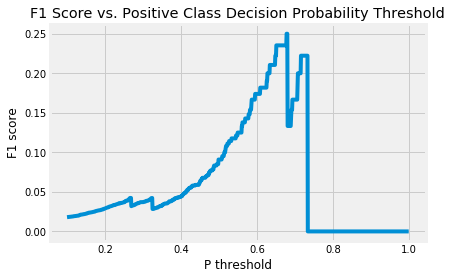

In [15]:
x_val, y_val = x_test_scaled, y_test # explicitly calling this validation since we're using it for selection

thresh_ps = np.linspace(.10,1,1000)
model_val_probs = rf2.predict_proba(x_val)[:,1] # positive class probs, same basic logistic model we fit in section 2 

f1_scores = []
for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    f1_scores.append(f1_score(model_val_labels, y_val))
    
plt.plot(thresh_ps, f1_scores)
plt.title('F1 Score vs. Positive Class Decision Probability Threshold')
plt.xlabel('P threshold')
plt.ylabel('F1 score')

best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]

print('Logistic Regression Model best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))

In [16]:
confusion_matrix(y_pred2, y_test)

array([[501,   3],
       [ 37,   2]])

In [17]:
column_names = X.loc[:,selection2].columns

In [18]:
coef = sorted(zip(column_names,abs(rf1.feature_importances_)), key=lambda x: -x[1])
coef

[('artist_familiarity', 0.1326001576749704),
 ('artist_hotttnesss', 0.11635977033127101),
 ('duration', 0.07498582013136822),
 ('tempo', 0.06426538108694146),
 ('loudness', 0.06197309095937152),
 ('mode', 0.060243488673994906),
 ('time_signature', 0.05928837108296388),
 ('key', 0.057989578513492616),
 ('year', 0.013549055276978377)]

TypeError: unhashable type: 'numpy.ndarray'

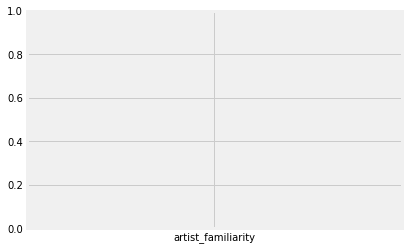

In [19]:
plt.bar(column_names, height=coef)

In [ ]:
##gradient boosting##

In [ ]:
gb1 = GradientBoostingClassifier(n_estimators = 1000, 
                                     learning_rate = .1,
                                    max_depth = 7)
gb1.fit(X_tr_smote, y_tr_smote)

y_pred1 = gb1.predict(x_test_scaled)

print('Gradient Boosting on SMOTE Train Data, ratio 0.4; Test F1: %.3f, Test AUC: %.3f, RMSE: %.3f' % \
      (f1_score(y_pred1, y_test), roc_auc_score(y_test, gb1.predict_proba(x_test_scaled)[:,1]), np.sqrt(np.sum((y_pred1 - y_test)**2)/len(y_test))))

In [ ]:
x_val, y_val = x_test_scaled, y_test # explicitly calling this validation since we're using it for selection

thresh_ps = np.linspace(.10,0.5,1000)
model_val_probs = gb1.predict_proba(x_val)[:,1]
f1_scores = []
for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    f1_scores.append(f1_score(model_val_labels, y_val))
    
plt.plot(thresh_ps, f1_scores)
plt.title('F1 Score vs. Positive Class Decision Probability Threshold')
plt.xlabel('P threshold')
plt.ylabel('F1 score')

best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]

print('Logistic Regression Model best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))

In [ ]:
gb1.plot_importance()

## XGBoost ##

In [ ]:
gb1 = GradientBoostingClassifier(n_estimators = 1000, 
                                     learning_rate = .1,
                                    max_depth = 7)
gb1.fit(X_tr_smote, y_tr_smote)

y_pred1 = gb1.predict(x_test_scaled)

print('Gradient Boosting on SMOTE Train Data, ratio 0.4; Test F1: %.3f, Test AUC: %.3f, RMSE: %.3f' % \
      (f1_score(y_pred1, y_test), roc_auc_score(y_test, gb1.predict_proba(x_test_scaled)[:,1]), np.sqrt(np.sum((y_pred1 - y_test)**2)/len(y_test))))

In [ ]:
x_val, y_val = x_test_scaled, y_test

thresh_ps = np.linspace(.10,0.5,1000)
model_val_probs = gb1.predict_proba(x_val)[:,1]
f1_scores = []
for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    f1_scores.append(f1_score(model_val_labels, y_val))
    
plt.plot(thresh_ps, f1_scores)
plt.title('F1 Score vs. Positive Class Decision Probability Threshold')
plt.xlabel('P threshold')
plt.ylabel('F1 score')

best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]

print('Logistic Regression Model best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))